<a href="https://colab.research.google.com/github/kaidalisohaib/AICohortW24/blob/Sohaib/notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!python --version

Python 3.10.12


## Step 1: Import necessary libraries

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

sns.set_context("notebook")

sns.set_theme(style="ticks")

## Step 2: Load the dataset

In [8]:
# input_file_path = "..\\data\\heart_disease_health_indicators_BRFSS2015.csv"
input_file_path = "https://raw.githubusercontent.com/kaidalisohaib/AICohortW24/main/data/heart_disease_health_indicators_BRFSS2015.csv"

df = pd.read_csv(input_file_path, header = 0)

df.head()

all_columns = df.columns.tolist()

# Define target column
target_column = "HeartDiseaseorAttack"

# Get all feature columns except one
all_features = all_columns
all_features.remove(target_column)

# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get non-numerical (categorical) columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("All the columns:\n", all_columns)
print("Target column:\n", target_column)
print("Features columns:\n", all_features)
print("Numerical Columns:\n",numerical_cols)
print("Categorical Columns:\n",categorical_cols)


All the columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Target column:
 HeartDiseaseorAttack
Features columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Numerical Columns:
 ['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Categorical Columns:
 []


## Step 3: Data exploration

### 3.1 Descriptive Statistics

In [9]:
# Print the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Get summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
print(df.describe())

# Get the count of unique values in each column
print("\nCount of unique values in each column:")
print(df.nunique())

print("\nCount of missing values:")
print(df.isnull().sum())

# Get the count of duplicate rows
print("\nCount of duplicated rows:")
print(df.duplicated(keep=False).sum())

# Value counts of a numerical variable
print("\nValue counts of a numerical variable:")
print(len(numerical_cols))

# Value counts of a categorical variable
print("\nValue counts of a categorical variable:")
print(len(categorical_cols))

First few rows of the dataset:
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  Di

### 3.2 Data Visualization

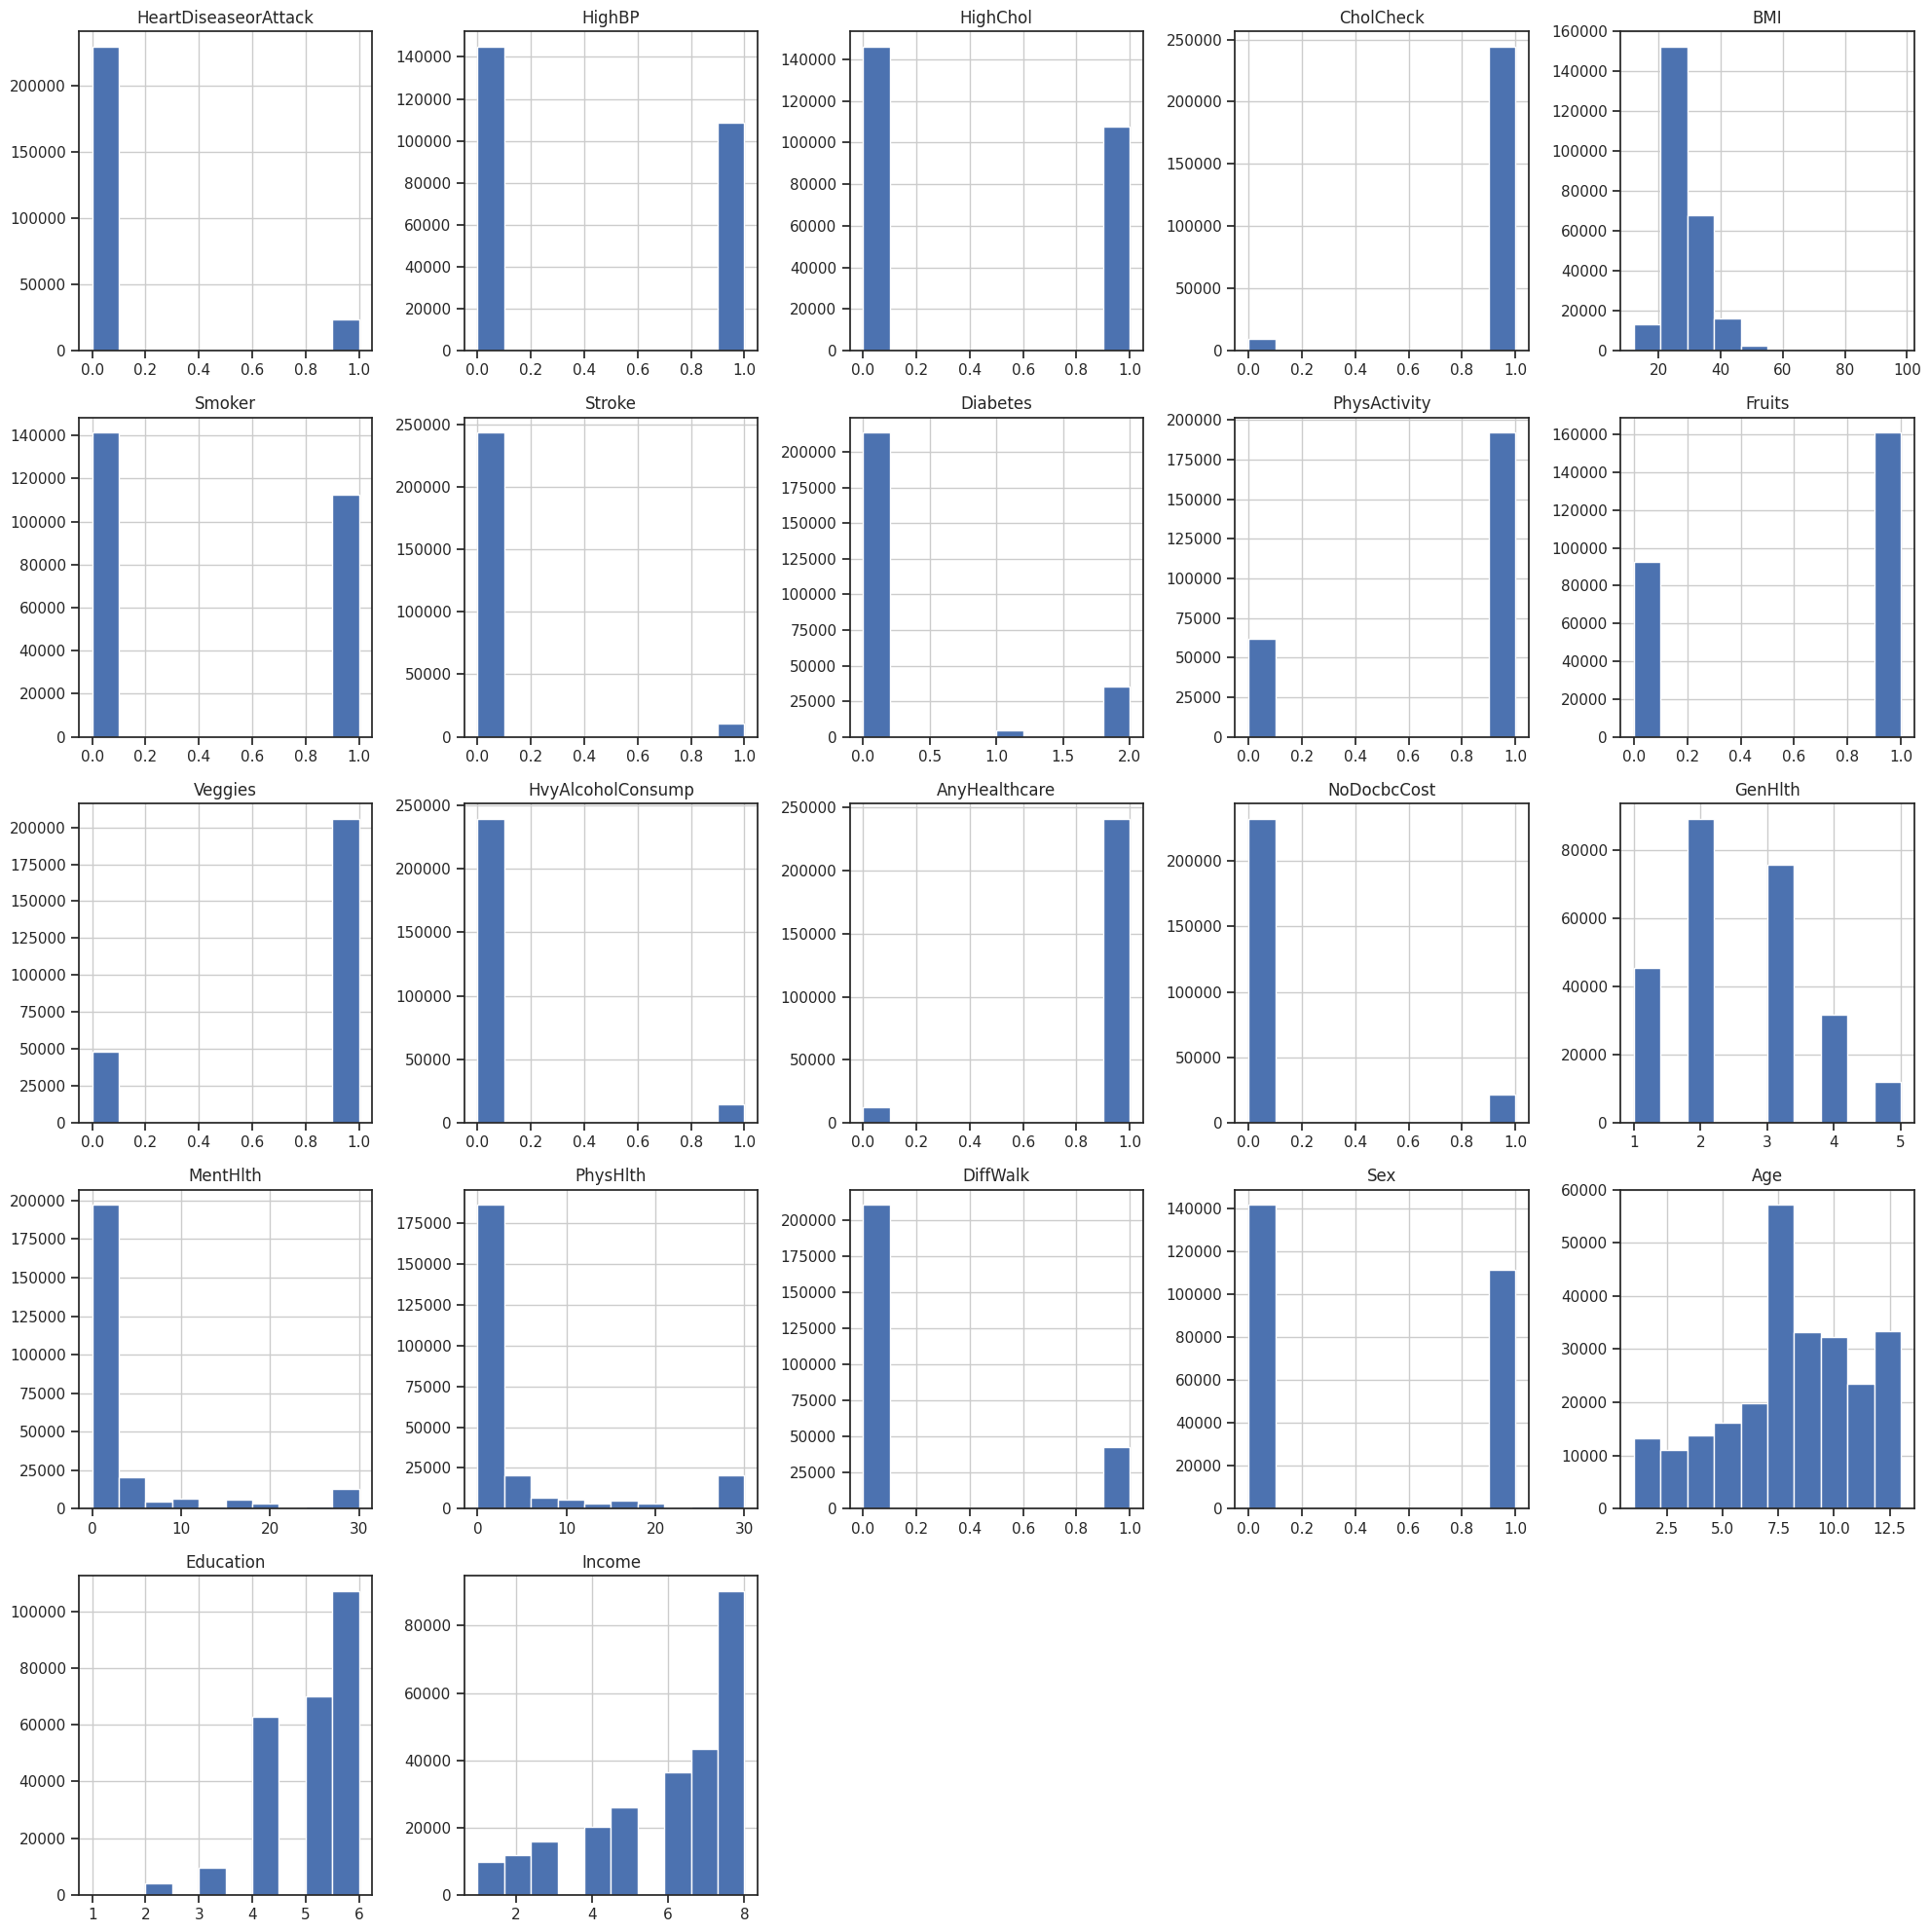

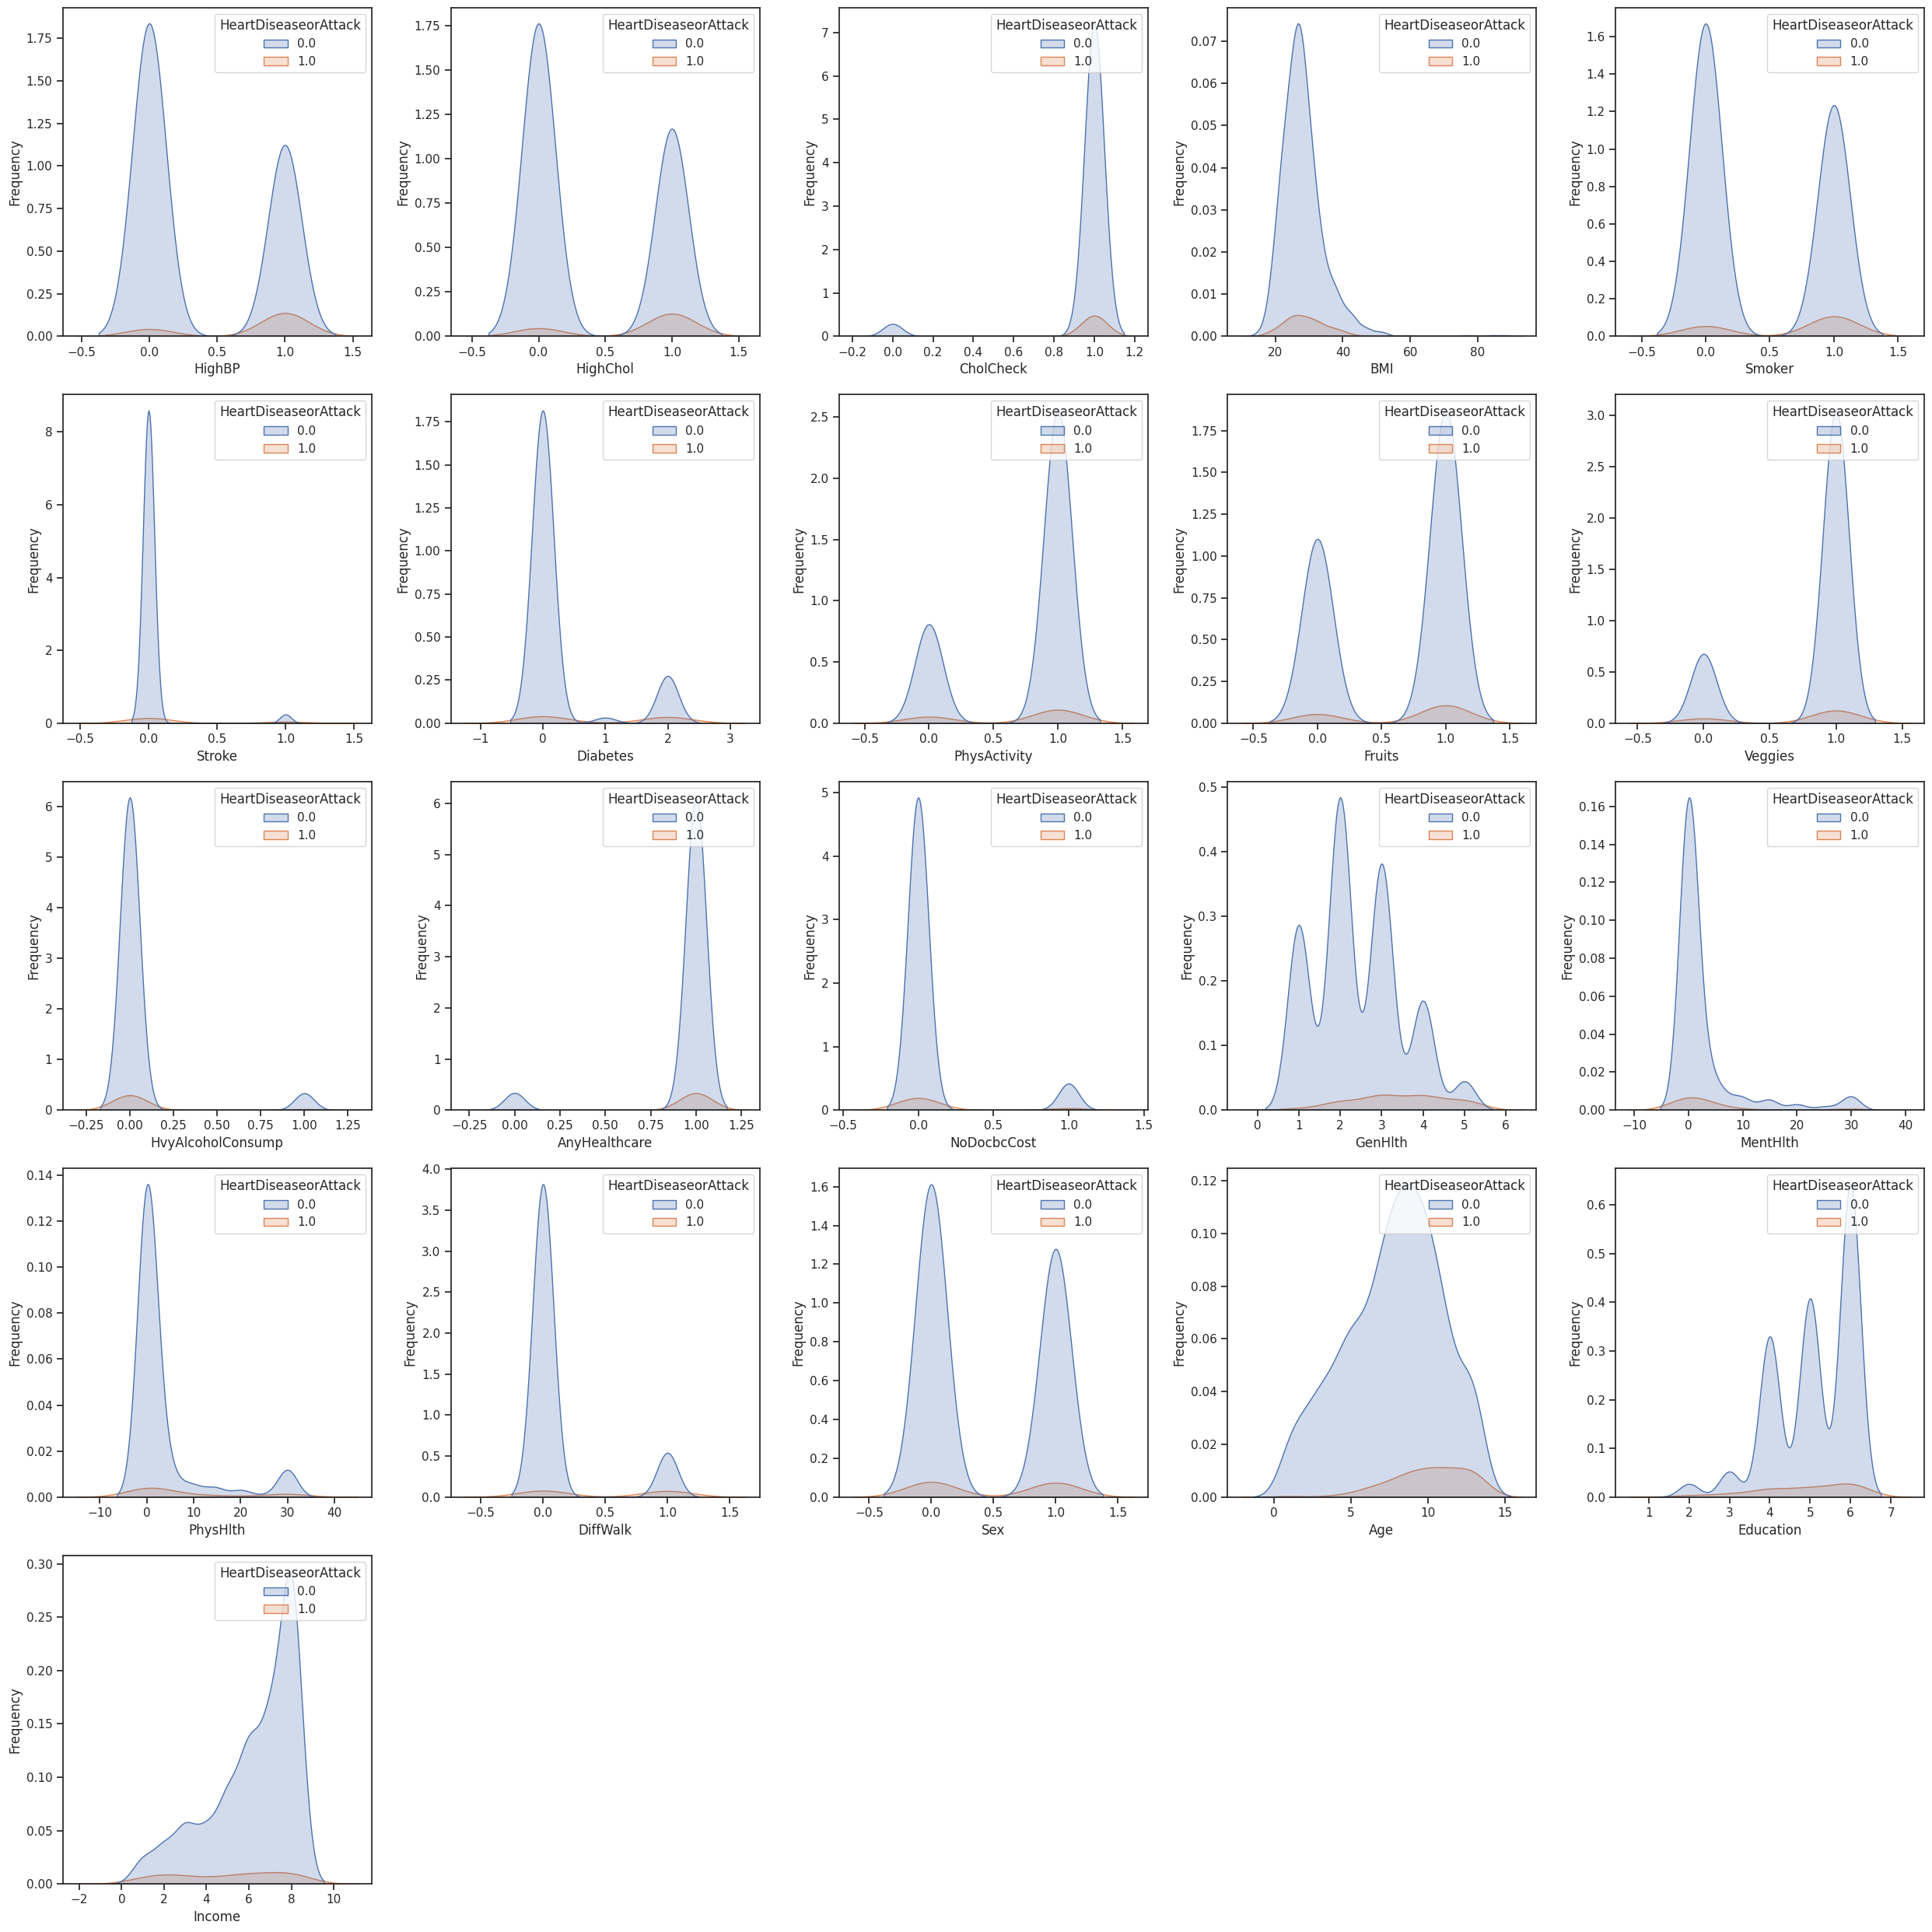

In [10]:
sample_df = df.sample(1_000)

df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

###########

# Determine the number of columns in the pairplot grid
num_cols = 5  # Adjust the number of columns as needed

# Calculate the number of rows needed for the pairplot grid
num_rows = (len(all_features) + num_cols - 1) // num_cols

# Create a single figure and axes for the pairplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

# Plot each feature against the target variable
for i, feature in enumerate(all_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.kdeplot(data=sample_df, x=feature, hue=target_column, fill=True, ax=ax)
    ax.set_ylabel("Frequency")

# Hide empty subplots
for i in range(len(all_features), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Show the combined pairplot image
plt.tight_layout()
plt.show()

### 3.3 Pattern identification

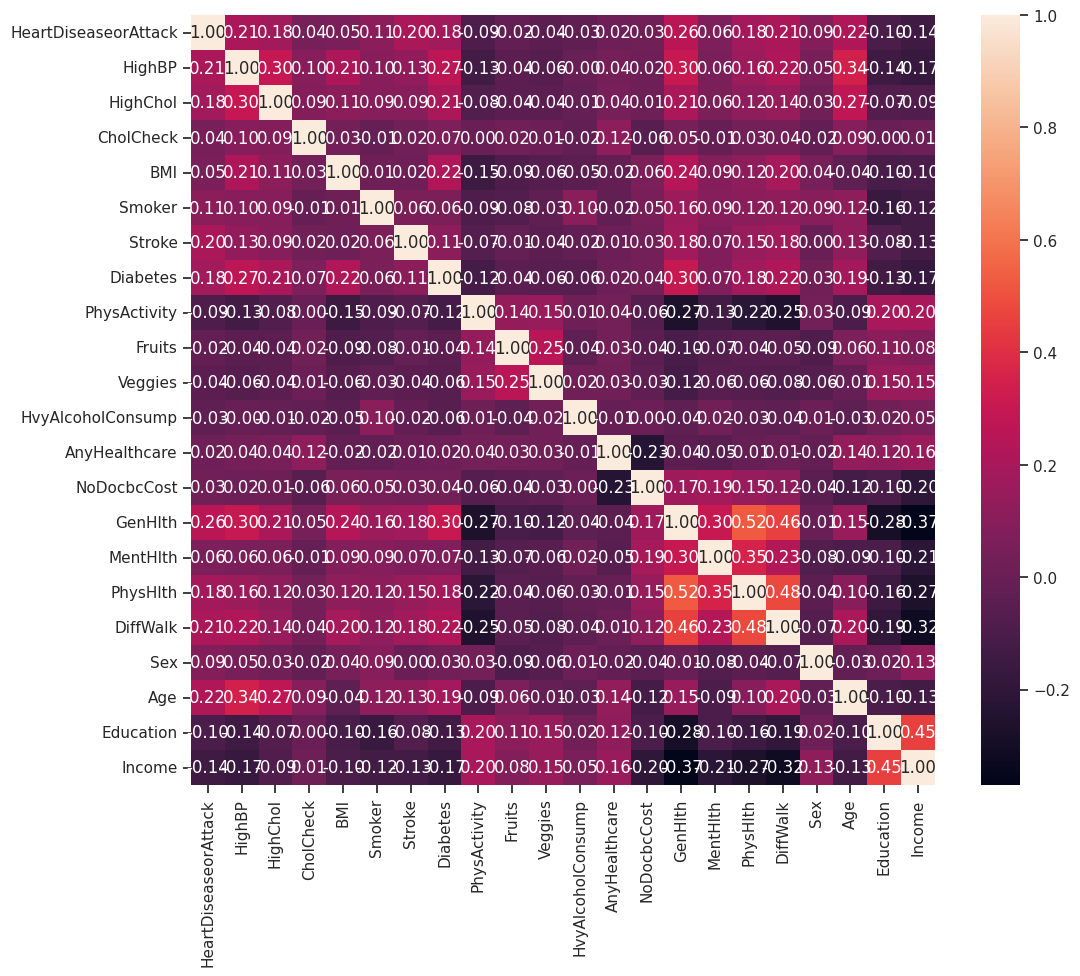

In [11]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## Step 4: Data preprocessing
TODO: Handle missing values, encode categorical variables, perform feature scaling, etc.

In [12]:
df.drop_duplicates(keep='first', inplace=True)
# No missing value so we're good

## Step 5: Data visualization
TODO: Visualize the data to gain insights (e.g., histograms, scatter plots, correlation matrix)

## Step 6: Split the dataset into train and test sets

## Step 7: Feature scaling

## Step 8: Model training

In [57]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

sample_df = df.sample(frac=0.1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sample_df[all_features], sample_df[target_column], test_size=0.2, random_state=42)

# Define resampling techniques
resampling_techniques = {
    'smote': SMOTE(random_state=42),
    'adasyn': ADASYN(random_state=42),
    'borderline_smote': BorderlineSMOTE(random_state=42),
    'svm_smote': SVMSMOTE(random_state=42),
    'random_under_sampler': RandomUnderSampler(random_state=42),
    'tomek_links': TomekLinks(),
    'edited_nearest_neighbours': EditedNearestNeighbours()
}

# Define classifiers
classifiers = {
    'rf': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'gb': GradientBoostingClassifier(random_state=42)
}

# Define pipelines for different strategies
pipelines = {}
for resampling_name, resampling_technique in resampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        pipe_name = f"{resampling_name}_{classifier_name}"
        pipelines[pipe_name] = ImbPipeline([
            ('resampling', resampling_technique),
            ('classifier', classifier)
        ])

# Define parameter grids for grid search
param_grids = {
    'rf': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20]
    },
    'gb': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

# Perform grid search and evaluate models
results = {}
for name, pipeline in pipelines.items():
    classifier_name = name.split('_')[-1]
    param_grid = param_grids[classifier_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', verbose=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    results[name] = {
        'best_model': best_model,
        'classification_report': report
    }

# Print results
for name, result in results.items():
    print(f"\n{name.upper()} MODEL:")
    print("Best Model Parameters:", result['best_model'].get_params())
    print("Classification Report:")
    print(result['classification_report'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END classifier__max_depth=10, classifier__n_estimators=100;, score=0.332 total time=   3.6s
[CV 2/3] END classifier__max_depth=10, classifier__n_estimators=100;, score=0.370 total time=   2.2s
[CV 3/3] END classifier__max_depth=10, classifier__n_estimators=100;, score=0.328 total time=   2.2s
[CV 1/3] END classifier__max_depth=10, classifier__n_estimators=200;, score=0.335 total time=   4.4s
[CV 2/3] END classifier__max_depth=10, classifier__n_estimators=200;, score=0.376 total time=   5.1s
[CV 3/3] END classifier__max_depth=10, classifier__n_estimators=200;, score=0.325 total time=   4.7s
[CV 1/3] END classifier__max_depth=20, classifier__n_estimators=100;, score=0.171 total time=   2.7s
[CV 2/3] END classifier__max_depth=20, classifier__n_estimators=100;, score=0.199 total time=   3.5s
[CV 3/3] END classifier__max_depth=20, classifier__n_estimators=100;, score=0.194 total time=   2.8s
[CV 1/3] END classifier__max_de

### Best model overall
ADASYN_GB MODEL:

Best Model Parameters:
```python
{'memory': None, 'steps': [('resampling', ADASYN(random_state=42)),
('classifier', GradientBoostingClassifier(n_estimators=50, random_state=42))],
'verbose': False, 'resampling': ADASYN(random_state=42),
'classifier': GradientBoostingClassifier(n_estimators=50, random_state=42),
'resampling__n_jobs': None,
'resampling__n_neighbors': 5,
'resampling__random_state': 42,
'resampling__sampling_strategy': 'auto',
'classifier__ccp_alpha': 0.0,
'classifier__criterion': 'friedman_mse',
'classifier__init': None,
'classifier__learning_rate': 0.1,
'classifier__loss': 'log_loss',
'classifier__max_depth': 3,
'classifier__max_features': None,
'classifier__max_leaf_nodes': None,
'classifier__min_impurity_decrease': 0.0,
'classifier__min_samples_leaf': 1,
'classifier__min_samples_split': 2,
'classifier__min_weight_fraction_leaf': 0.0,
'classifier__n_estimators': 50,
'classifier__n_iter_no_change': None,
'classifier__random_state': 42,
'classifier__subsample': 1.0,
'classifier__tol': 0.0001,
'classifier__validation_fraction': 0.1,
'classifier__verbose': 0,
'classifier__warm_start': False}
```
Classification Report:          
    precision    recall  f1-score   support

          0.0       0.93      0.94      0.93      4119
          1.0       0.41      0.35      0.37       477

    accuracy                            0.88      4596
    macro avg       0.67      0.64      0.65      4596
    weighted avg    0.87      0.88      0.88      4596

## Step 9: Model evaluation

## Step 10: Confusion matrix

## Step 11: Classification report